In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from scipy.spatial.transform import Rotation as R

# Find latest simulation folder
log_folder = r"C:\Adaptive Satellite Control\adaptive-satellite-control\Simulation_2026-01-03_17-58-59"

In [111]:
state = pd.read_csv(os.path.join(log_folder, 'state.csv'))
inputs = pd.read_csv(os.path.join(log_folder, 'input.csv'))
env = pd.read_csv(os.path.join(log_folder, 'environment.csv'))
est = pd.read_csv(os.path.join(log_folder, 'estimation.csv'))

# Convert time strings to datetime objects
state['t'] = pd.to_datetime(state['t'], format='ISO8601')
inputs['t'] = pd.to_datetime(inputs['t'], format='ISO8601')
env['t'] = pd.to_datetime(env['t'], format='ISO8601')
est['t'] = pd.to_datetime(est['t'], format='ISO8601')

# Calculate elapsed time in seconds
t0 = state['t'][0]
state['t'] = (state['t'] - t0).dt.total_seconds() / 3600
inputs['t'] = (inputs['t'] - t0).dt.total_seconds() / 3600
env['t'] = (env['t'] - t0).dt.total_seconds() / 3600
est['t'] = (est['t'] - t0).dt.total_seconds() / 3600

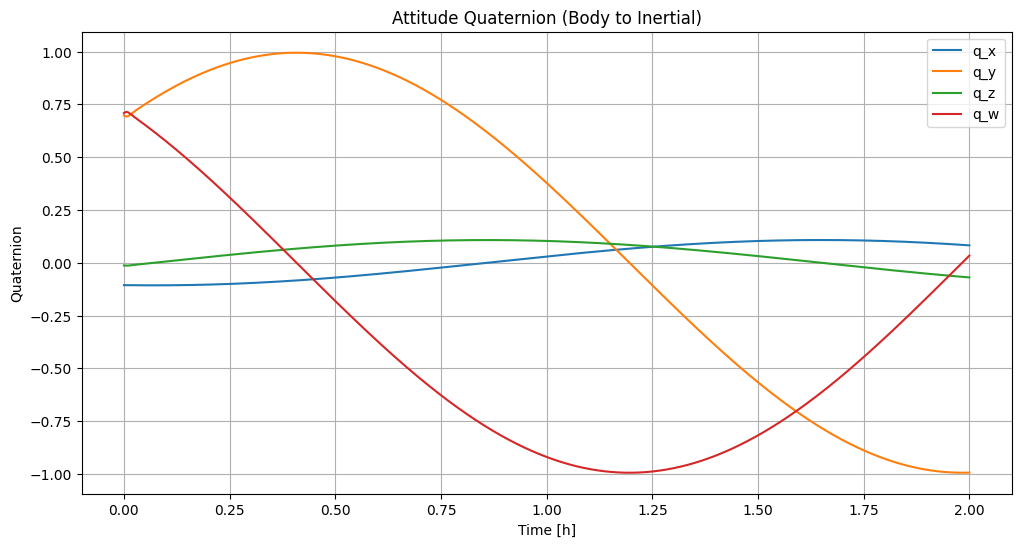

In [112]:
# Plot Attitude (Quaternions)
plt.figure(figsize=(12, 6))
plt.plot(state['t'], state['q_BI_x'], label='q_x')
plt.plot(state['t'], state['q_BI_y'], label='q_y')
plt.plot(state['t'], state['q_BI_z'], label='q_z')
plt.plot(state['t'], state['q_BI_w'], label='q_w')
plt.title('Attitude Quaternion (Body to Inertial)')
plt.xlabel('Time [h]')
plt.ylabel('Quaternion')
plt.legend()
plt.grid(True)
plt.show()

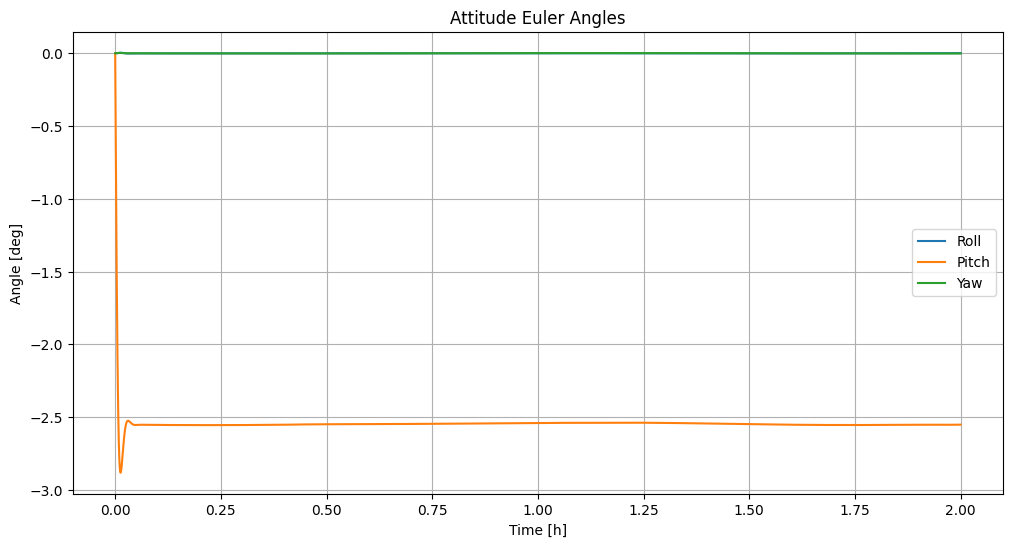

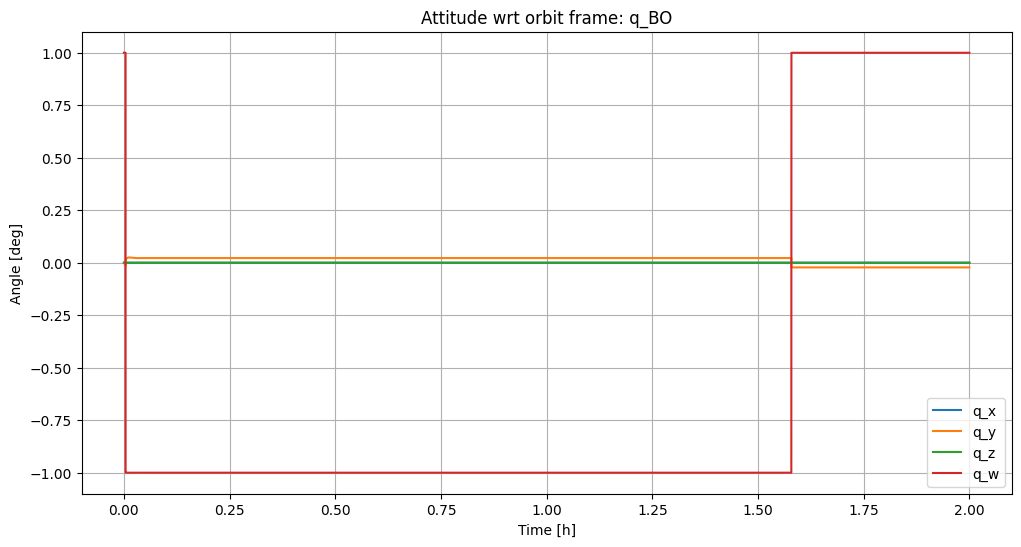

In [ ]:
from kinematics import orc_to_sbc, to_euler
quats = state[['q_BI_x', 'q_BI_y', 'q_BI_z', 'q_BI_w']].to_numpy()
r_eci, v_eci = state[['r_eci_x', 'r_eci_y', 'r_eci_z']], state[['v_eci_x', 'v_eci_y', 'v_eci_z']]
euler = to_euler(quats, r_eci, v_eci)
q_BO = orc_to_sbc(quats, r_eci, v_eci).as_quat()
plt.figure(figsize=(12, 6))
plt.plot(state['t'], euler[:, 0], label='Roll')
plt.plot(state['t'], euler[:, 1], label='Pitch')
plt.plot(state['t'], euler[:, 2], label='Yaw')
plt.title('Attitude Euler Angles')
plt.xlabel('Time [h]')
plt.ylabel('Angle [deg]')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(state['t'], q_BO, label=["q_x", "q_y", "q_z", "q_w"])
plt.title('Attitude wrt orbit frame: q_BO')
plt.xlabel('Time [h]')
plt.ylabel('Quaternion')
plt.legend()
plt.grid(True)
plt.show()

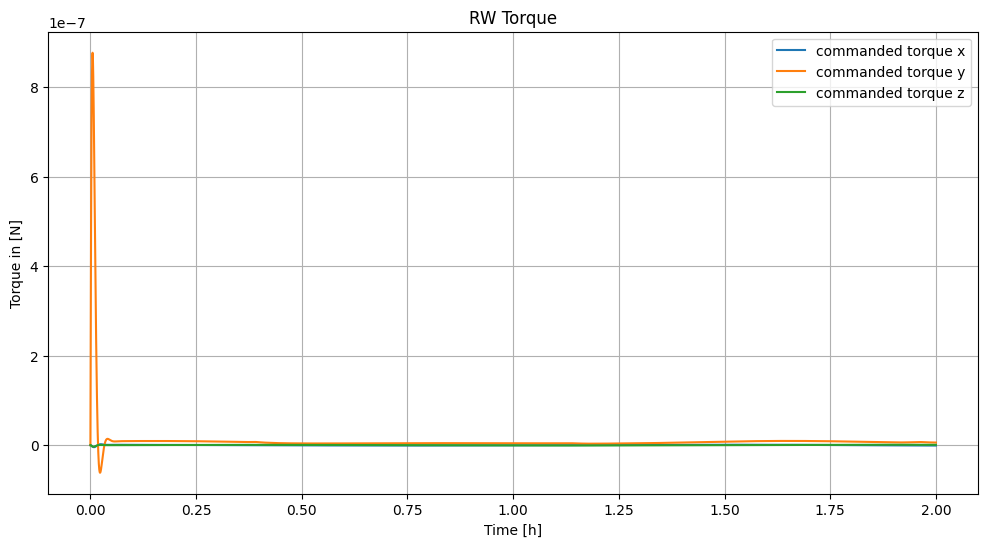

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(inputs['t'], inputs['u_rw_1'], label='commanded torque x')
plt.plot(inputs['t'], inputs['u_rw_2'], label='commanded torque y')
plt.plot(inputs['t'], inputs['u_rw_3'], label='commanded torque z')
# plt.plot(state['t'], state['i_mag_1'], color="tab:blue", linestyle="--", label='current 1')
# plt.plot(state['t'], state['i_mag_2'], color="tab:orange", linestyle="--", label='current 2')
# plt.plot(state['t'], state['i_mag_3'], color="tab:green", linestyle="--", label='current 3')
plt.title('RW Torque')
plt.xlabel('Time [h]')
plt.ylabel('Torque in [N]')
plt.legend()
plt.grid(True)
plt.show()

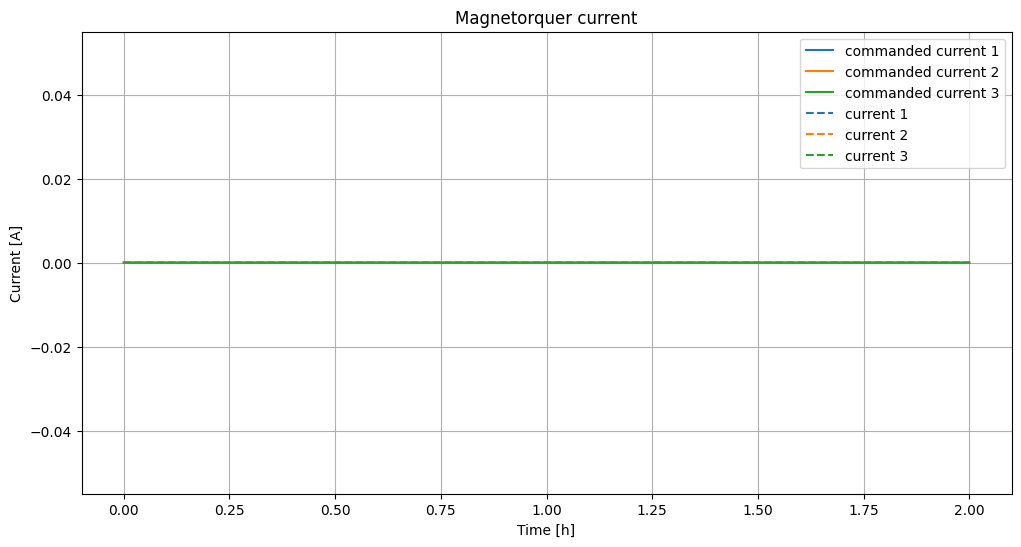

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(inputs['t'], inputs['i_cmd_mag_1'], label='commanded current 1')
plt.plot(inputs['t'], inputs['i_cmd_mag_2'], label='commanded current 2')
plt.plot(inputs['t'], inputs['i_cmd_mag_3'], label='commanded current 3')
plt.plot(state['t'], state['i_mag_1'], color="tab:blue", linestyle="--", label='current 1')
plt.plot(state['t'], state['i_mag_2'], color="tab:orange", linestyle="--", label='current 2')
plt.plot(state['t'], state['i_mag_3'], color="tab:green", linestyle="--", label='current 3')
plt.title('Magnetorquer current')
plt.xlabel('Time [h]')
plt.ylabel('Current [A]')
plt.legend()
plt.grid(True)
plt.show()

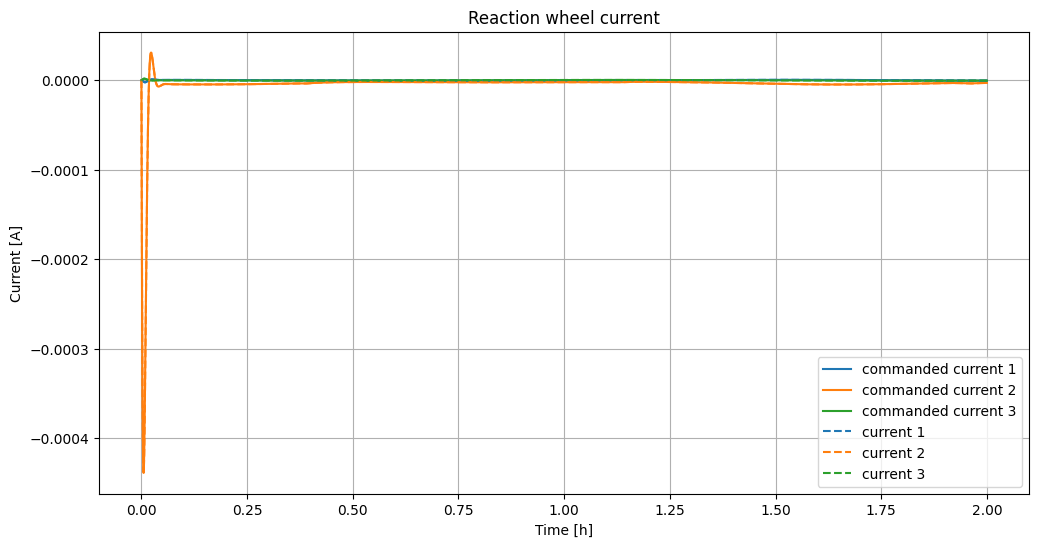

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(inputs['t'], inputs['i_cmd_rw_1'], label='commanded current 1')
plt.plot(inputs['t'], inputs['i_cmd_rw_2'], label='commanded current 2')
plt.plot(inputs['t'], inputs['i_cmd_rw_3'], label='commanded current 3')
plt.plot(state['t'], state['i_rw_1'], color="tab:blue", linestyle="--", label='current 1')
plt.plot(state['t'], state['i_rw_2'], color="tab:orange", linestyle="--", label='current 2')
plt.plot(state['t'], state['i_rw_3'], color="tab:green", linestyle="--", label='current 3')
plt.title('Reaction wheel current')
plt.xlabel('Time [h]')
plt.ylabel('Current [A]')
plt.legend()
plt.grid(True)
plt.show()

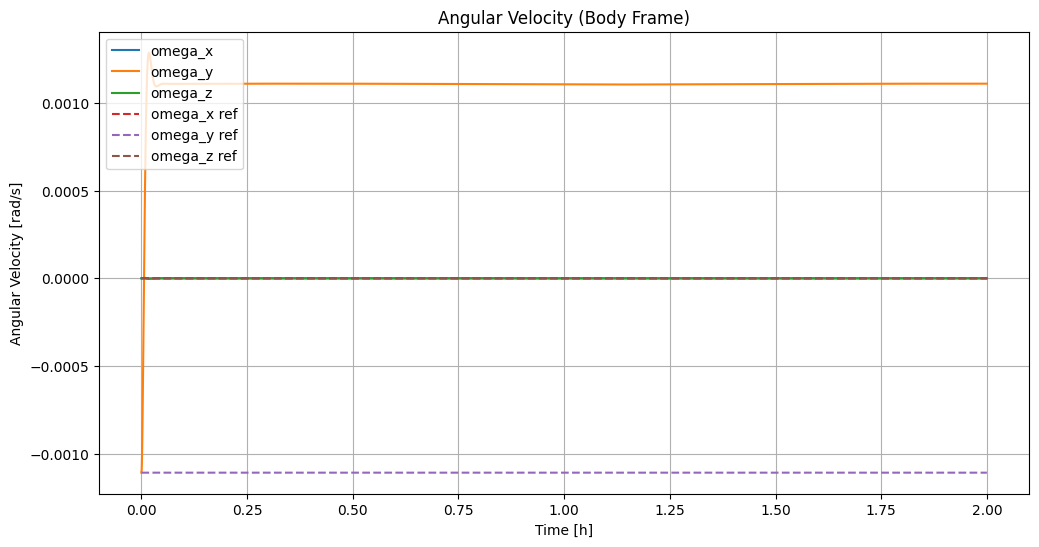

In [117]:
# Plot Angular Velocity
omega_0 = np.linalg.norm(v_eci)/ np.linalg.norm(r_eci)
omega_c =  orc_to_sbc(quats, r_eci, v_eci).apply([0, -omega_0, 0])

tab_colors = ["tab:blue", "tab:orange", "tab:green"]
colors_dark = ["blue", "orange", "green"]
plt.figure(figsize=(12, 6))
plt.plot(state['t'], state[["omega_x", "omega_y", "omega_z"]], label=["omega_x", "omega_y", "omega_z"])
plt.plot(state['t'], omega_c, linestyle="--", label=['omega_x ref', 'omega_y ref', 'omega_z ref'])

plt.title('Angular Velocity (Body Frame)')
plt.xlabel('Time [h]')
plt.ylabel('Angular Velocity [rad/s]')
plt.legend()
plt.grid(True)
plt.show()

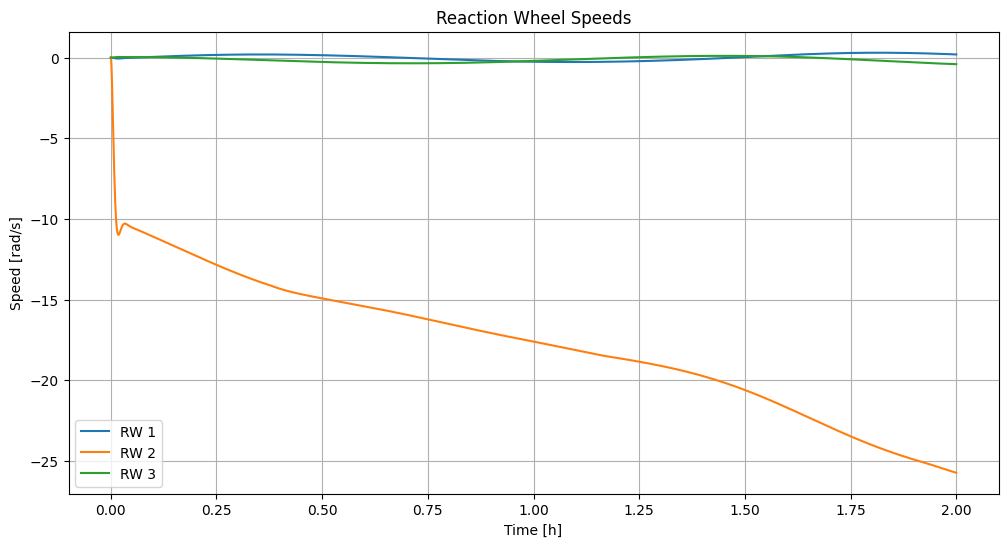

In [118]:
# Plot Reaction Wheel Speeds
plt.figure(figsize=(12, 6))
plt.plot(state['t'], state['omega_rw_1'], label='RW 1')
plt.plot(state['t'], state['omega_rw_2'], label='RW 2')
plt.plot(state['t'], state['omega_rw_3'], label='RW 3')
plt.title('Reaction Wheel Speeds')
plt.xlabel('Time [h]')
plt.ylabel('Speed [rad/s]')
plt.legend()
plt.grid(True)
plt.show()

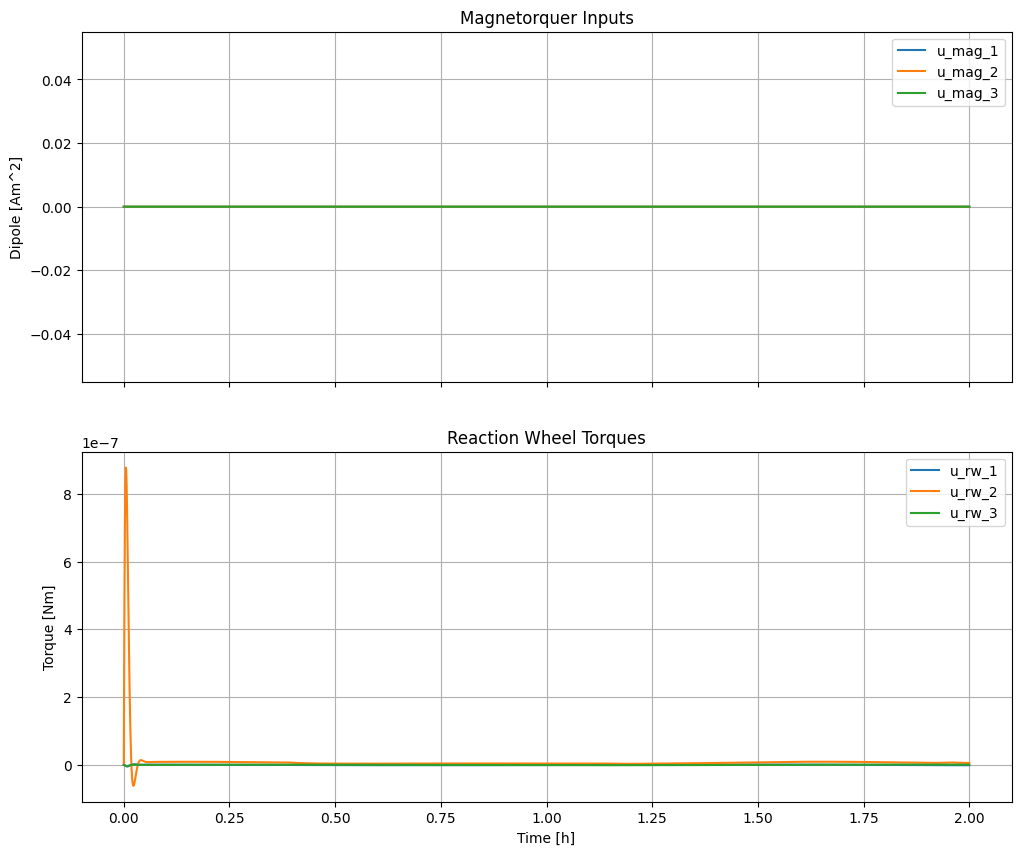

In [119]:
# Plot Control Inputs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(inputs['t'], inputs['u_mag_1'], label='u_mag_1')
ax1.plot(inputs['t'], inputs['u_mag_2'], label='u_mag_2')
ax1.plot(inputs['t'], inputs['u_mag_3'], label='u_mag_3')
ax1.set_title('Magnetorquer Inputs')
ax1.set_ylabel('Dipole [Am^2]')
ax1.legend()
ax1.grid(True)

ax2.plot(inputs['t'], inputs['u_rw_1'], label='u_rw_1')
ax2.plot(inputs['t'], inputs['u_rw_2'], label='u_rw_2')
ax2.plot(inputs['t'], inputs['u_rw_3'], label='u_rw_3')
ax2.set_title('Reaction Wheel Torques')
ax2.set_xlabel('Time [h]')
ax2.set_ylabel('Torque [Nm]')
ax2.legend()
ax2.grid(True)

plt.show()

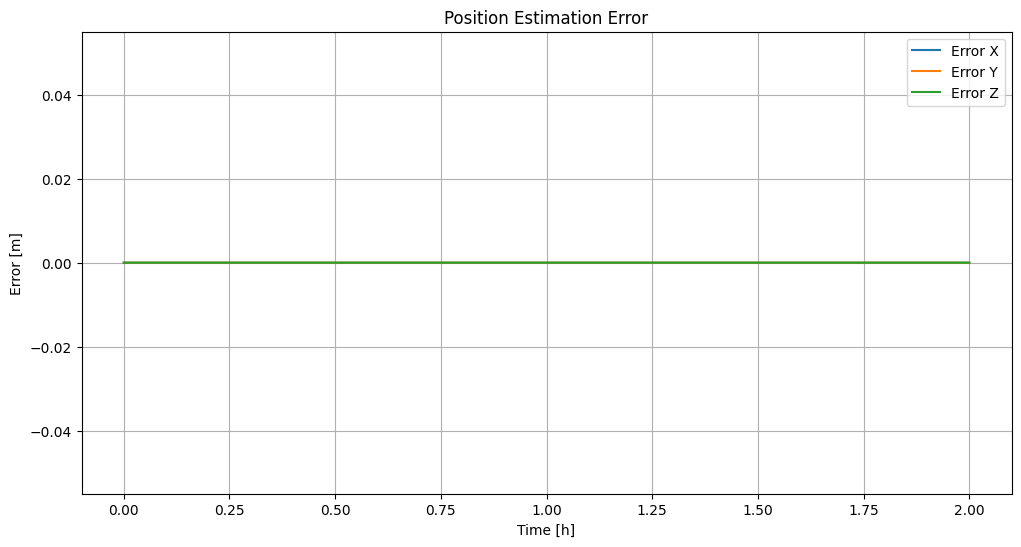

In [120]:
# Plot Estimation Error (Position)
plt.figure(figsize=(12, 6))
plt.plot(est['t'], est['r_eci_x'] - state['r_eci_x'], label='Error X')
plt.plot(est['t'], est['r_eci_y'] - state['r_eci_y'], label='Error Y')
plt.plot(est['t'], est['r_eci_z'] - state['r_eci_z'], label='Error Z')
plt.title('Position Estimation Error')
plt.xlabel('Time [h]')
plt.ylabel('Error [m]')
plt.legend()
plt.grid(True)
plt.show()